# <span style="color:pink"> AUTORES </span>
 
* **<span style="color:pink"> Sebastián Kay Conde Lorenzo </span>**
* **<span style="color:pink"> Francisco Manuel López López </span>**

# <span style="color:red">¿DÓNDE ENCONTRAR LAS IMÁGENES, NOTAS Y DEMÁS?</span>

**<span style="color:red">PARA ENCONTRAR EL PROYECTO COMPLETO DE ESTOS NOTEBOOKS (INCLUYENDO LA ESTRUCTURA DE CARPETAS E IMÁGENES USADAS) POR FAVOR VISITAR ESTE [REPOSITORIO](https://github.com/cbasitodx/Image_Processing_Course)**</span>

# Procesamiento de Imágenes

En este notebook aprenderás sobre:
1. Ecualización de histograma
2. Extracción de características usando Haralick Features
3. Umbralización de Otsu con operaciones morfológicas
4. Comparación de plantillas mediante convolución

In [1]:
# Initial configuration

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, exposure, measure
from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import disk, square
from skimage.filters import threshold_otsu, rank
from scipy.signal import convolve2d
import cv2

## Ecualización del histograma

La equalización del histograma es una técnica de procesamiento de imágenes que se utiliza para mejorar el contraste de una imagen ajustando la distribución de sus intensidades de píxel. Su objetivo principal es redistribuir los valores de intensidad de manera que el histograma de la imagen resultante sea lo más uniforme posible.

### Procedimiento
1. Calcular el histograma acumulativo: Se genera el histograma acumulativo de la imagen, que indica la suma acumulada de las frecuencias de intensidad.
2. Normalizar el histograma acumulativo: Se escala el histograma acumulativo para que sus valores estén en el rango del nivel de intensidad permitido (por ejemplo, de 0 a 255).
3. Asignar nuevos valores de intensidad: Cada nivel de intensidad original se reasigna a un nuevo nivel según el histograma acumulativo normalizado. Esto expande o contrae el rango de valores según sea necesario.
4. Generar la imagen resultante: Se aplica la nueva asignación de valores a la imagen original, obteniendo una imagen con un contraste mejorado.

In [2]:
def equalize_hist(image):
    # Scale the image to values between 0-255
    image = (image * 255).astype(np.uint8)
    # Compute the normal histogram
    histogram, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    # Compute the cumulative histogram
    cumulative_histogram = np.cumsum(histogram)
    # Normalize the cumulative histogram
    cumulative_histogram_normalized = cumulative_histogram / cumulative_histogram[-1]
    # Create an intensity mapping table
    new_intensities = np.round(cumulative_histogram_normalized * 255).astype(np.uint8)
    # Apply the mapping table to the original image
    equalized_image = new_intensities[image]
    return equalized_image

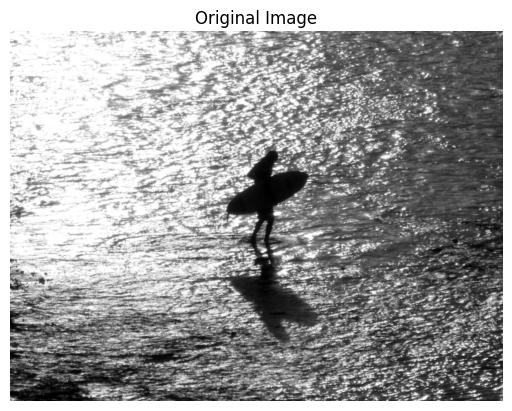

In [3]:
# Load an image
image = io.imread('imagenes/notebook_3/surfer.jpg', as_gray=True)

# Display the original image
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

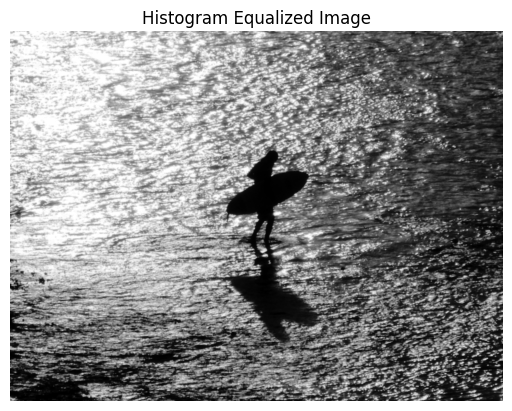

In [4]:
# Histogram Equalization using scikit-image
equalized_image = equalize_hist(image)

# Display the equalized image
plt.title("Histogram Equalized Image")
plt.imshow(equalized_image, cmap='gray')
plt.axis('off')
plt.show()

## Actividad A:

A1. Cargue una imagen diferente y realice la ecualización del histograma.

A2. Compare el histograma de la imagen original y la imagen ecualizada.

### Apartado A1 & A2:

Escogemos, intencionalmente, una imágen que tenga un contraste "malo" y distintos tipos de texturas.

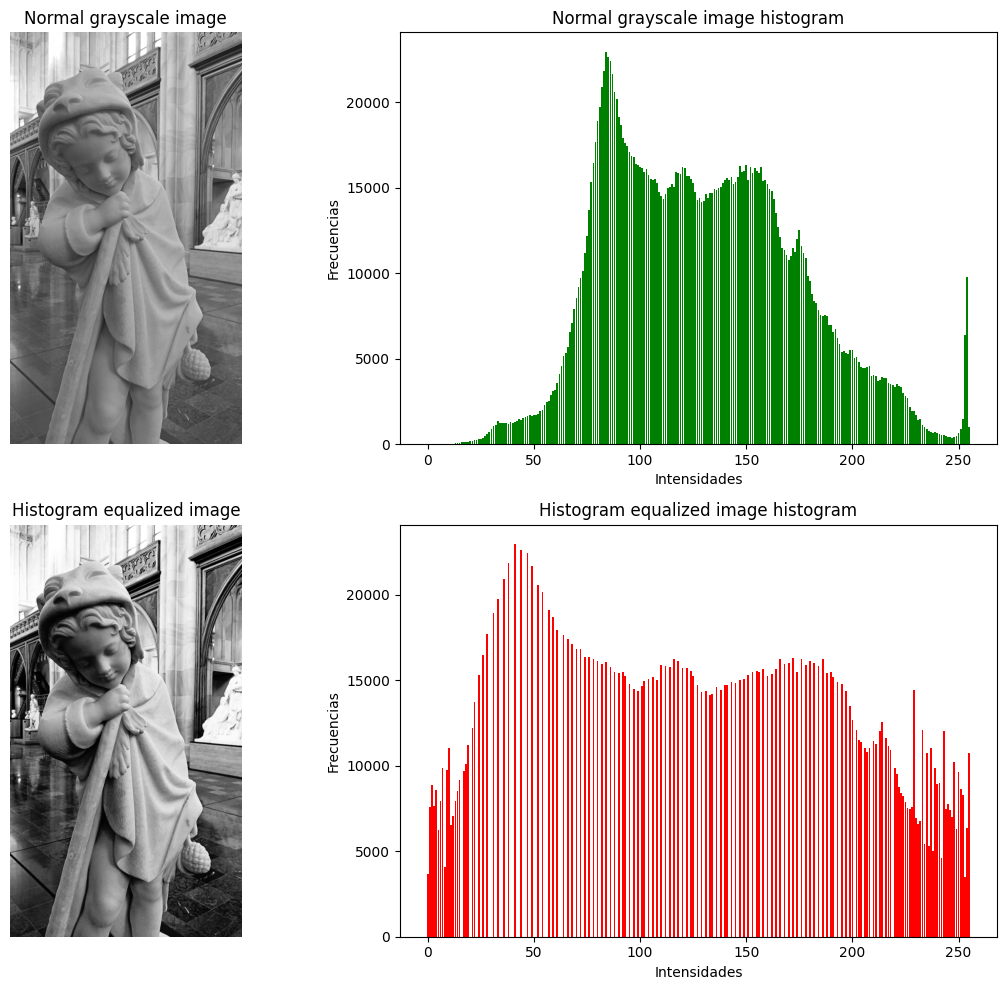

In [5]:
# Empezamos cargando la imagen en escala de grises (sus valores seran reales y en [0, 1])
statue_image = io.imread('imagenes/notebook_3/statue.jpg', as_gray=True)

# Ahora, extraemos su histograma (considerando los pixeles de la imagen con valores enteros de 0 a 255)
statue_histogram, statue_bins = np.histogram((255 * statue_image).astype(np.uint8).flatten(), bins=256, range=[0, 256])

# Equalizamos el histograma de la imagen
statue_image_equalized = equalize_hist(statue_image)

# Obtenemos el histograma de la imagen con el histograma equalizado
statue_histogram_equalized, statue_bins_equalized = np.histogram(statue_image_equalized.flatten(), bins=256, range=[0, 256])

# Graficamos las imagenes con sus histogramas
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Normal grayscale image")
plt.imshow(statue_image, cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Normal grayscale image histogram")
plt.bar(x=list(range(0,256)), height=statue_histogram, color="green")
plt.xlabel("Intensidades")
plt.ylabel("Frecuencias")

plt.subplot(2, 2, 3)
plt.title("Histogram equalized image")
plt.imshow(statue_image_equalized, cmap='gray')
plt.axis('off')

plt.subplot(2,2,4)
plt.title("Histogram equalized image histogram")
plt.bar(x=list(range(0,256)), height=statue_histogram_equalized, color="red")
plt.xlabel("Intensidades")
plt.ylabel("Frecuencias")

plt.tight_layout()
plt.show()

## Extracción de Características de Haralick

Las características de Haralick son un conjunto de descriptores de textura que se calculan a partir de la matriz de co-ocurrencia de niveles de gris (GLCM, por sus siglas en inglés: Grey-Level Co-occurrence Matrix). Estas características se utilizan comúnmente en análisis de imágenes para describir la textura de una región, permitiendo identificar patrones repetitivos y diferencias sutiles en la estructura de las imágenes.

### ¿Qué es la GLCM?

La GLCM es una matriz que mide la frecuencia relativa con la que dos niveles de intensidad específicos ($i$ y $j$) ocurren en una relación espacial dada dentro de una imagen.
Por ejemplo:

- Relación espacial: Un píxel y su vecino a la derecha, arriba, abajo, o en diagonal.
- Niveles de gris: Cada nivel representa una intensidad en la imagen (en una imagen de 8 bits, los niveles son 0 a 255).

Cada elemento de la GLCM ($P(i,j)$) representa la cantidad de veces que un píxel con intensidad $i$ se encuentra adyacente (según la relación espacial definida) a un píxel con intensidad $j$.

### Características de Haralick

Haralick propuso 14 características derivadas de la GLCM para describir la textura de una imagen. Algunas de las más utilizadas son:

#### Contraste:
- Evalúa la intensidad del contraste entre un píxel y sus vecinos.
- Valores altos indican una textura con grandes diferencias de intensidad.

$\text{Contraste} = \sum_{i,j} P(i, j) \cdot (i - j)^2$

#### Correlación:

- Mide cuán correlacionados están los niveles de intensidad de los píxeles adyacentes.
- Valores cercanos a 1 indican alta correlación.

$\text{Correlación} = \frac{\sum_{i,j} P(i,j) \cdot (i - \mu_i) \cdot (j - \mu_j)}{\sigma_i \cdot \sigma_j}$

Donde: 
- $\mu_i$: Media de los niveles de intensidad en $i$.
- $\mu_j$: Media de los niveles de intensidad en $j$.
- $\sigma_i$: Desviación estándar de $i$.
- $\sigma_j$: Desviación estándar de $j$.

#### Energía:

- Mide la uniformidad o el orden en la distribución de los valores de la GLCM.
- Valores altos indican una textura repetitiva.

$\text{Energía} = \sum_{i,j} P(i, j)^2$

#### Homogeneidad:

- Evalúa cuán similares son los valores de la GLCM cerca de la diagonal principal ($i=j$).
- Valores altos indican una textura homogénea.

$\text{Homogeneidad} = \sum_{i,j} \frac{P(i, j)}{1 + |i - j|}$

## Proceso para Calcular las Características de Haralick

1. Convertir la Imagen a Escala de Grises: Para simplificar, se usa una imagen en escala de grises.
2. Calcular la GLCM: Se define una distancia ($d$) y un ángulo ($\theta$) para determinar la relación espacial entre los píxeles.
3. Obtener las Características de Haralick:
4. A partir de la GLCM, se calculan las características usando las fórmulas mencionadas.

In [6]:
# Compute GLCM
glcm = graycomatrix((image * 255).astype('uint8'), distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

# Extract Haralick features
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]

print("Haralick Features:")
print(f"Contrast: {contrast}")
print(f"Correlation: {correlation}")
print(f"Homogeneity: {homogeneity}")
print(f"Energy: {energy}")


Haralick Features:
Contrast: 1795.2336547411285
Correlation: 0.8326122878515898
Homogeneity: 0.0810843495888909
Energy: 0.01911244309148176


## Actividad B:

B1. Modifica los parámetros de distancia y ángulo del cálculo GLCM. Observa el impacto en las características Haralick.

B2. Con los valores originales calcula la características de Haralick de dos imágenes con diferentes texturas.

### Apartado 1:

Cargamos una imágen con algún patrón repetitivo; con una textura interesante. Luego, dibujamos sus GLCM y observamos sus características de Haralick

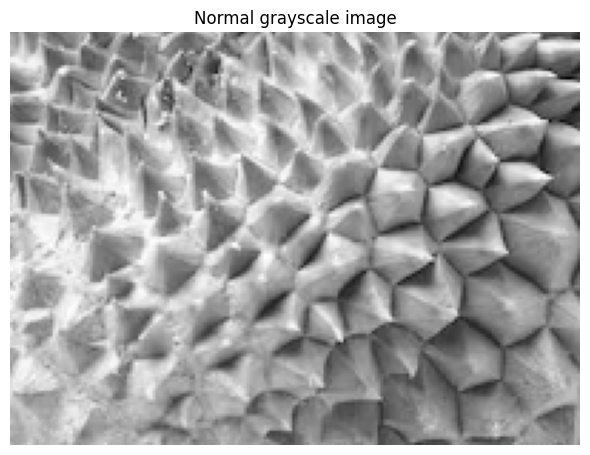

 
Haralick Features with distance 5 and angle 0:
Durian image contrast: 2131.303059239611
Durian image correlation: 0.408203312404597
Durian image homogeneity: 0.029808267472820362
Durian image energy: 0.008107285779113132
 


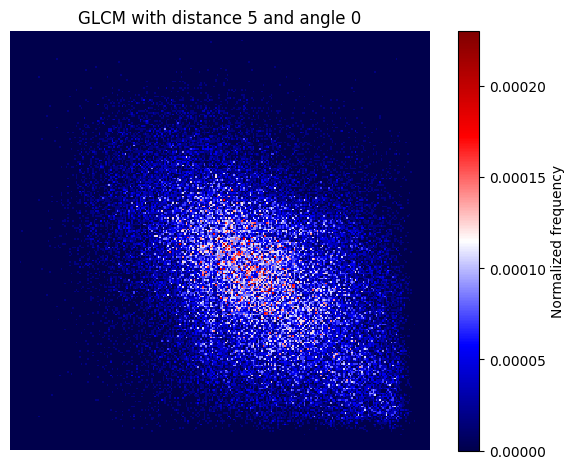

 
Haralick Features with distance 10 and angle 0:
Durian image contrast: 2920.6717967332124
Durian image correlation: 0.18982029462262298
Durian image homogeneity: 0.021837655895566382
Durian image energy: 0.007816686590892984
 


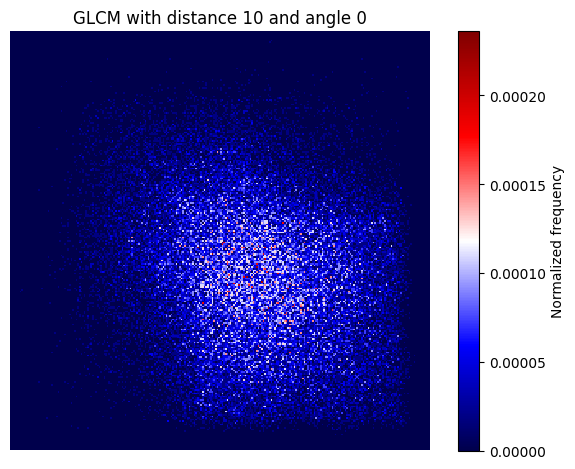

 
Haralick Features with distance 15 and angle 0:
Durian image contrast: 2777.8508853681265
Durian image correlation: 0.2259976020472214
Durian image homogeneity: 0.022927045462327898
Durian image energy: 0.007887189717443135
 


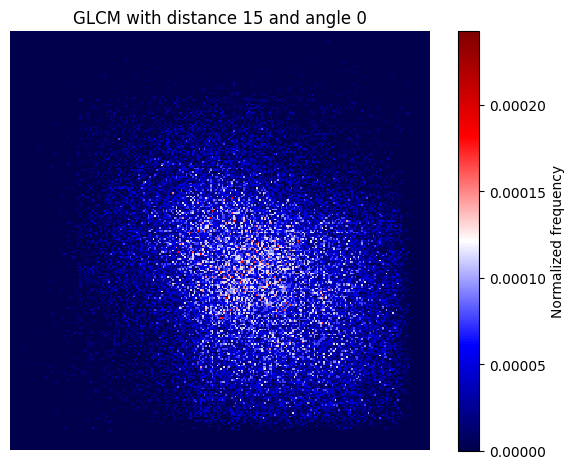

 
Haralick Features with distance 20 and angle 0:
Durian image contrast: 2636.2382375478933
Durian image correlation: 0.26268270293604645
Durian image homogeneity: 0.023443800752117043
Durian image energy: 0.00795888828676864
 


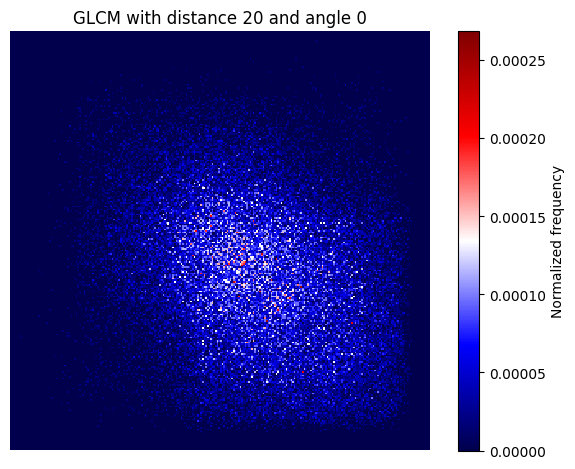

In [7]:
# Cargamos la primera imagen
durian_image = io.imread('imagenes/notebook_3/durian.jpg', as_gray=True)

# Definimos distancias y angulos a usar
distances = [5, 10, 15, 20]
angles = [0]

# Ensenamos la imagen
plt.figure(figsize=(6, 6))
plt.imshow(durian_image, cmap='gray')
plt.title("Normal grayscale image")
plt.axis('off')
plt.tight_layout()
plt.show()

# Iteramos por las distancias y los angulos
for d in distances:
    for a in angles:  
        # Calculamos la GLCM de la imagen cargada 
        glcm_durian = graycomatrix((durian_image * 255).astype('uint8'), distances=[d,], angles=[a,], levels=256, symmetric=True, normed=True)

        # Extraemos las caracteristicas de Haralick
        contrast_durian    = graycoprops(glcm_durian, 'contrast')[0, 0]
        correlation_durian = graycoprops(glcm_durian, 'correlation')[0, 0]
        homogeneity_durian = graycoprops(glcm_durian, 'homogeneity')[0, 0]
        energy_durian      = graycoprops(glcm_durian, 'energy')[0, 0]

        print(" ")
        print(f"Haralick Features with distance {d} and angle {a}:")
        print(f"Durian image contrast: {contrast_durian}")
        print(f"Durian image correlation: {correlation_durian}")
        print(f"Durian image homogeneity: {homogeneity_durian}")
        print(f"Durian image energy: {energy_durian}")
        print(" ")

        # Dibujamos la glcm
        plt.figure()
        plt.imshow(glcm_durian[:, :, 0, 0], cmap="seismic", interpolation='nearest')
        plt.title(f"GLCM with distance {d} and angle {a}")
        plt.colorbar(label='Normalized frequency')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

### Apartado 2:

Cargamos otra imágen que tenga una textura distinta y, usando una distancia de 5 y un ángulo de 0, dibujamos ambas imágenes, sus GLCM's y observamos sus características de Haralick

**** IMAGE 1 HARALICK FEATURES ****
 
Haralick Features of the first image with distance 5 and angle 0:
Image 1 contrast: 2131.303059239611
Image 1 correlation: 0.408203312404597
Image 1 homogeneity: 0.029808267472820362
Image 1 energy: 0.008107285779113132
 
**** IMAGE 2 HARALICK FEATURES ****
 
Haralick Features of the second image with distance 5 and angle 0:
Image 2 contrast: 26.315474127974127
Image 2 correlation: 0.9928538766121734
Image 2 homogeneity: 0.5371664766892364
Image 2 energy: 0.0705731320900391
 


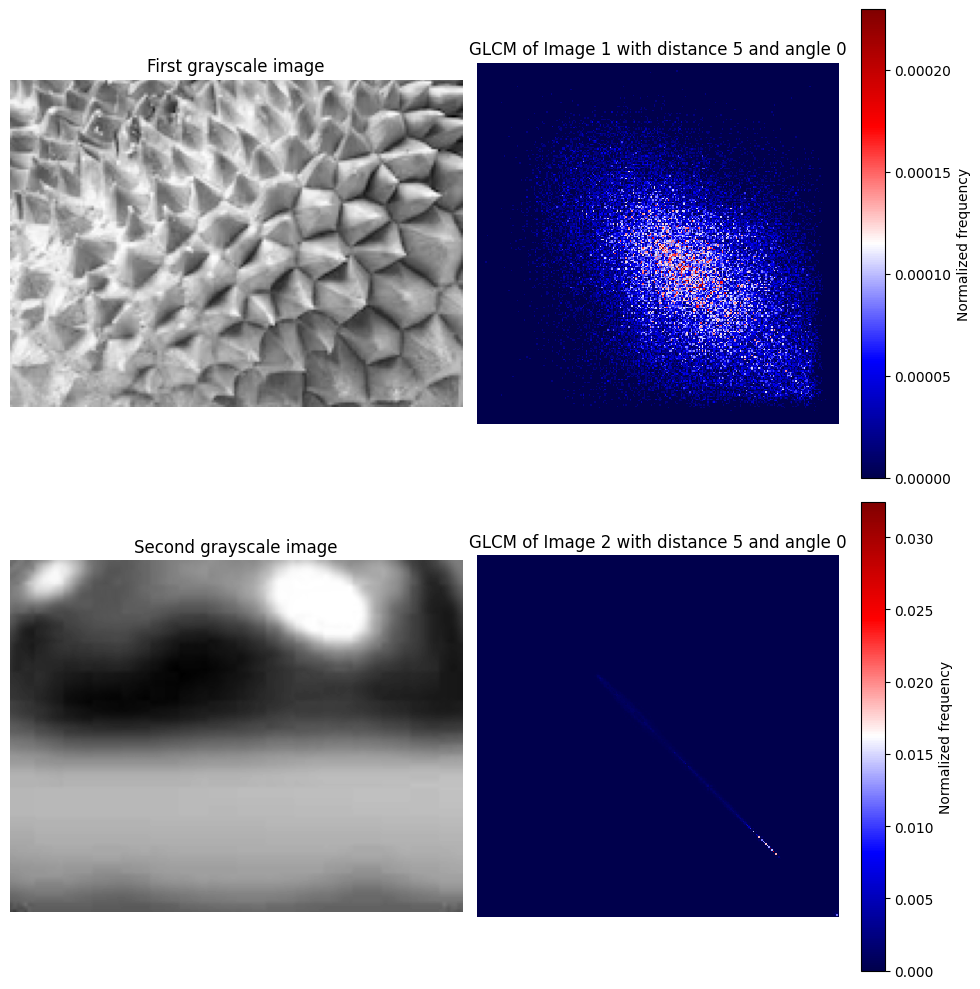

In [8]:
# Definimos distancia y angulo
d = 5
a = 0

# Cargamos la segunda imagen
metal_image = io.imread('imagenes/notebook_3/metal.jpg', as_gray=True)

# Calculamos la GLCM de ambas imagenes 
glcm_durian = graycomatrix((durian_image * 255).astype('uint8'), distances=[d,], angles=[a,], levels=256, symmetric=True, normed=True)
glcm_metal  = graycomatrix((metal_image  * 255).astype('uint8'), distances=[d,], angles=[a,], levels=256, symmetric=True, normed=True)

# Extraemos sus caracteristicas de Haralick
contrast_durian    = graycoprops(glcm_durian, 'contrast')[0, 0]
correlation_durian = graycoprops(glcm_durian, 'correlation')[0, 0]
homogeneity_durian = graycoprops(glcm_durian, 'homogeneity')[0, 0]
energy_durian      = graycoprops(glcm_durian, 'energy')[0, 0]

contrast_metal    = graycoprops(glcm_metal, 'contrast')[0, 0]
correlation_metal = graycoprops(glcm_metal, 'correlation')[0, 0]
homogeneity_metal = graycoprops(glcm_metal, 'homogeneity')[0, 0]
energy_metal      = graycoprops(glcm_metal, 'energy')[0, 0]

# Las imprimimos por pantalla
print("**** IMAGE 1 HARALICK FEATURES ****")
print(" ")
print(f"Haralick Features of the first image with distance {d} and angle {a}:")
print(f"Image 1 contrast: {contrast_durian}")
print(f"Image 1 correlation: {correlation_durian}")
print(f"Image 1 homogeneity: {homogeneity_durian}")
print(f"Image 1 energy: {energy_durian}")
print(" ")

print("**** IMAGE 2 HARALICK FEATURES ****")
print(" ")
print(f"Haralick Features of the second image with distance {d} and angle {a}:")
print(f"Image 2 contrast: {contrast_metal}")
print(f"Image 2 correlation: {correlation_metal}")
print(f"Image 2 homogeneity: {homogeneity_metal}")
print(f"Image 2 energy: {energy_metal}")
print(" ")

# Ahora ploteamos las imagenes y sus GLCM'set
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(durian_image, cmap='gray')
plt.title("First grayscale image")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(glcm_durian[:, :, 0, 0], cmap="seismic", interpolation='nearest')
plt.title(f"GLCM of Image 1 with distance {d} and angle {a}")
plt.colorbar(label='Normalized frequency')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(metal_image, cmap='gray')
plt.title("Second grayscale image")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(glcm_metal[:, :, 0, 0], cmap="seismic", interpolation='nearest')
plt.title(f"GLCM of Image 2 with distance {d} and angle {a}")
plt.colorbar(label='Normalized frequency')
plt.axis('off')

plt.tight_layout()
plt.show()

## Método de Otsu y Operaciones Morfológicas

### Método de Otsu

El método de Otsu es una técnica de umbralización automática utilizada para segmentar una imagen en dos clases: fondo y objeto. Este método encuentra el umbral óptimo que maximiza la separación entre las dos clases en términos de varianza.

#### Cálculo del Umbral Óptimo

1. Dividir la Imagen en Clases: Para un valor de umbral $t$, la imagen se divide en:
- Clase 1 ($C_1$): Píxeles con intensidades $\leq t$.
- Clase 2 ($C_2$): Píxeles con intensidades $> t$.

2. Probabilidades de las Clases:
  $ P(C_1) = \sum_{i=0}^{t} P(i), \quad P(C_2) = \sum_{i=t+1}^{L-1} P(i)$ 

donde $P(i)$ es la probabilidad de cada nivel de intensidad, calculada como la frecuencia relativa.

3. Medias de las Clases:
   $ \mu_1 = \frac{\sum_{i=0}^{t} i \cdot P(i)}{P(C_1)}, \quad \mu_2 = \frac{\sum_{i=t+1}^{L-1} i \cdot P(i)}{P(C_2)} $

4. Varianza entre Clases:
$ \sigma_b^2 = P(C_1) \cdot P(C_2) \cdot (\mu_1 - \mu_2)^2 $

5. Umbral Óptimo: El valor de $t$ que maximiza $\sigma_b^2$ es el umbral óptimo.

### Operaciones Morfológicas

Las operaciones morfológicas son técnicas de procesamiento que manipulan la estructura de los objetos en una imagen binaria, utilizando un elemento estructurante.

#### Operaciones Básicas

- Erosión: Elimina píxeles del borde de los objetos.

    $A \ominus B = \{ z \in E : B_z \subseteq A \}$

- Dilatación: Añade píxeles al borde de los objetos.

  $ A \oplus B = \{ z \in E : B_z \cap A \neq \emptyset \} $

- Apertura: Erosión seguida de dilatación, elimina ruido pequeño.

$ A \circ B = (A \ominus B) \oplus B $

- Cierre: Dilatación seguida de erosión, rellena agujeros pequeños.

$ A \bullet B = (A \oplus B) \ominus B$

####  Elementos Estructurantes

Un elemento estructurante es una pequeña matriz que define la vecindad utilizada en las operaciones morfológicas. Ejemplos:

- Disco: Suaviza bordes circulares.
- Cuadrado: Mantiene formas rectangulares.

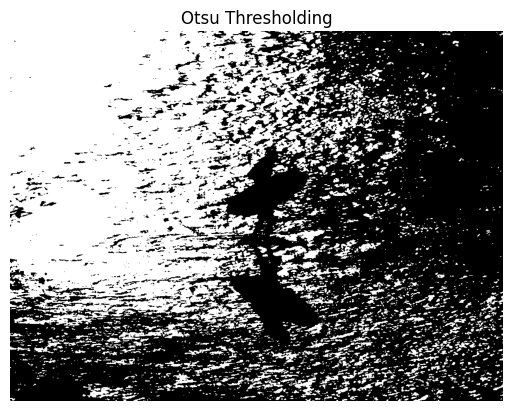

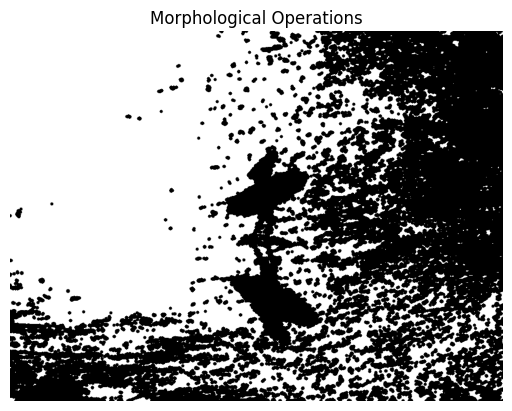

In [9]:
# Otsu's method automatically determines the optimal threshold value to separate foreground and background in an image.
# Morphological operations, such as dilation and erosion, help refine the segmentation.

# Otsu's Thresholding
otsu_thresh = threshold_otsu(image)
binary_image = image > otsu_thresh

# Perform Morphological Operations
selem = disk(3)
cleaned_image = morphology.binary_closing(binary_image, selem)

# Display the results
plt.title("Otsu Thresholding")
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()

plt.title("Morphological Operations")
plt.imshow(cleaned_image, cmap='gray')
plt.axis('off')
plt.show()

## Actividad C:
C1. Experimenta con diferentes elementos estructurales (disco, cuadrado) y dos diferentes tamaños para las operaciones morfológicas.

C2. Prueba el método de Otsu con otra imagen.

### Apartados 1 & 2:

Vamos a cargar una imágen del dataset ARCADE (*Automatic Region-based Coronary Artery Disease diagnostics using x-ray angiography imagEs Dataset*), que contiene una radiografía de una arteria. Luego, intentaremos segmentar esta arteria usando thresholding y morfología.

In [10]:
def segment_artery(binary_image : np.ndarray, density_thresh : float) -> np.ndarray:
    # Creamos una mascara para mantener las regiones con menor densidad (estas contendran la arteria segmentada)
    mask = np.zeros_like(binary_image, dtype=np.uint8)

    # Ahora vamos a extraer las componentes conexas de la imagen binaria. Una vez las tengamos, podemos eliminar las que tengan mucha "densidad" de valores oscuros. 
    # Haciendo esto podremos quedarnos con la arteria
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(1 - binary_image, connectivity=8) # Invertimos la imagen para tener mejores resultados. Con "connectivity=8" le decimos a opencv que considere los vecinos diagonales tambien
    
    # Iteramos extrayendo la densidad de cada componente conexa. 
    # Esta se obtiene como el cociente del area de la componente conexa entre el area de su bounding box (siempre que el area de la bounding box no sea 0)
    for i in range(1, num_labels):  # Saltamos el fondo (etiqueta 0)
        area = stats[i, cv2.CC_STAT_AREA]
        bbox_area = stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT]
        density = area / bbox_area if bbox_area > 0 else 0

        # Filtramos por densidad
        if density < density_thresh:
            mask[labels == i] = 255

    # Retornamos la mascara
    return mask

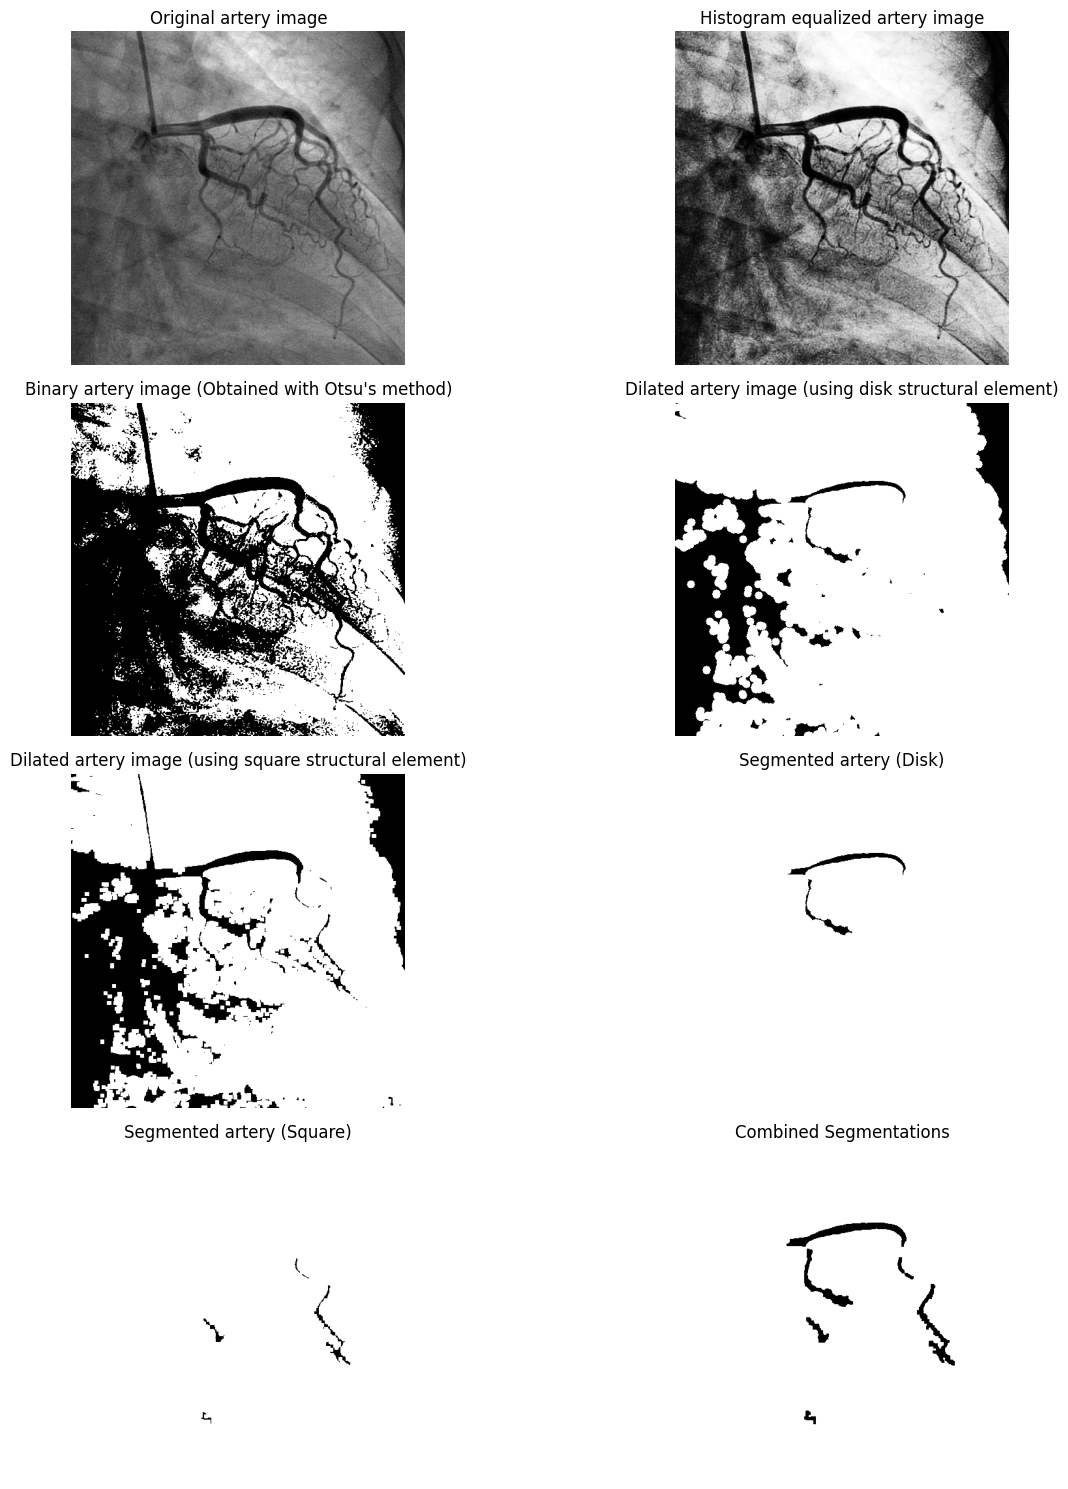

In [11]:
# Empezamos cargando la imagen de la arteria
artery_image = io.imread('imagenes/notebook_3/arteria.jpg', as_gray=True)

# La equalizamos para mejorar el contraste
artery_image_equalized = equalize_hist(artery_image)

# Le aplicamos el thresholding de Otsu para convertirla en una imágen binaria (**APARTADO 2**)
otsu_thresh_artery = threshold_otsu(artery_image_equalized)
binary_image_artery = artery_image_equalized > otsu_thresh_artery
binary_image_artery = binary_image_artery.astype(np.int8)

# Aplicamos una dilatacion usando elementos estructurales (**APARTADO 1**). Estas dilataciones deben ser grandes para separar la arteria de la "Mancha negra" que se aprecia en la foto
disk_struct_elem   = disk(6)
square_struct_elem = square(6)

disk_cleaned_image   = morphology.dilation(binary_image_artery, disk_struct_elem)
square_cleaned_image = morphology.dilation(binary_image_artery, square_struct_elem)

# Definimos dos umbrales de densidad (una para la imagen modificada con el elemento estructural en forma de disco y otra para la modificada con el elem. estructural cuadrado)
disk_density_thresh   = 0.30
square_density_thresh = 0.27

# Segmentamos la arteria (obtenemos dos mascaras, una por elemento estructural)
disk_mask   = segment_artery(disk_cleaned_image, disk_density_thresh)
square_mask = segment_artery(square_cleaned_image, square_density_thresh)

# Invertimos las mascaras para devolverlas a su forma original
disk_segmented   = cv2.bitwise_not(disk_mask)
square_segmented = cv2.bitwise_not(square_mask)

# Mostramos los resultados
N_ROWS = 4
N_COLS = 2

plt.figure(figsize=(15, 15))

plt.subplot(N_ROWS, N_COLS, 1)
plt.title("Original artery image")
plt.imshow(artery_image, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS, N_COLS, 2)
plt.title("Histogram equalized artery image")
plt.imshow(artery_image_equalized, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS, N_COLS, 3)
plt.title("Binary artery image (Obtained with Otsu's method)")
plt.imshow(binary_image_artery, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS, N_COLS, 4)
plt.title("Dilated artery image (using disk structural element)")
plt.imshow(disk_cleaned_image, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS, N_COLS, 5)
plt.title("Dilated artery image (using square structural element)")
plt.imshow(square_cleaned_image, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS, N_COLS, 6)
plt.title("Segmented artery (Disk)")
plt.imshow(disk_segmented, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS, N_COLS,7)
plt.title("Segmented artery (Square)")
plt.imshow(square_segmented, cmap='gray')
plt.axis('off')

# Combinamos las segmentaciones y le damos un poco de anchira con una erosion
small_square_struct_elem = square(4)
combined_segmentation  = morphology.erosion(cv2.bitwise_and(disk_segmented, square_segmented), small_square_struct_elem)

plt.subplot(N_ROWS, N_COLS, 8)
plt.title("Combined Segmentations")
plt.imshow(combined_segmentation, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Template Matching con Correlación Cruzada Normalizada

El template matching es una técnica utilizada en procesamiento de imágenes para localizar un patrón o plantilla (template) dentro de una imagen más grande. Una forma común de realizarlo es utilizando la correlación cruzada normalizada (NCC, por sus siglas en inglés).

### Definición de Correlación Cruzada Normalizada

La correlación cruzada normalizada mide la similitud entre un patrón (template) $T(u, v)$ y una región correspondiente de la imagen $I(x, y)$. Su fórmula se expresa como:

$
NCC(x, y) = \frac{\sum_{u, v} \left( I(x+u, y+v) - \mu_I \right) \cdot \left( T(u, v) - \mu_T \right)}{\sqrt{\sum_{u, v} \left( I(x+u, y+v) - \mu_I \right)^2 \cdot \sum_{u, v} \left( T(u, v) - \mu_T \right)^2}}
$

Donde:
- $I(x+u, y+v)$: Es la región de la imagen bajo la plantilla $T(u, v)$.
- $\mu_I$: Es la media de la intensidad en la región de la imagen.
- $\mu_T$: Es la media de la intensidad de la plantilla.
- El denominador normaliza los valores, haciéndolos independientes de la escala de intensidad.

### Pasos del Algoritmo

1. Definir la plantilla (template) $T(u, v)$: Una subregión pequeña de la imagen que queremos localizar.
2. Extraer regiones de la imagen: Para cada posición $(x, y)$, extraer una región del mismo tamaño que la plantilla.
3. Calcular la NCC: En cada posición, calcular el valor de $NCC(x, y)$ utilizando la fórmula anterior.
4. Localizar el mejor emparejamiento: Identificar la posición $(x, y)$ donde $NCC(x, y)$ es máximo. Esta posición corresponde al mejor emparejamiento entre la plantilla y la imagen.


In [12]:
def template_match(image, template):
    # Get dimensions of image and template
    img_h, img_w = image.shape
    tmpl_h, tmpl_w = template.shape
    
    # Compute mean of the template
    tmpl_mean = np.mean(template)
    
    # Initialize result matrix
    result = np.zeros((img_h - tmpl_h + 1, img_w - tmpl_w + 1))
    
    # Slide the template over the image
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            # Extract the region of the image under the template
            region = image[i:i+tmpl_h, j:j+tmpl_w]
            
            # Compute mean of the region
            region_mean = np.mean(region)
            
            # Compute numerator (cross-correlation)
            numerator = np.sum((region - region_mean) * (template - tmpl_mean))
            
            # Compute denominator (normalization)
            denominator = np.sqrt(np.sum((region - region_mean) ** 2) * np.sum((template - tmpl_mean) ** 2))
            
            # Avoid division by zero
            if denominator != 0:
                result[i, j] = numerator / denominator
            else:
                result[i, j] = 0
    
    return result

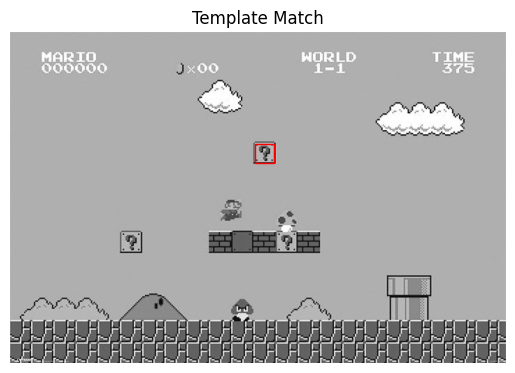

In [13]:
image = io.imread('imagenes/notebook_3/super_mario.jpg', as_gray=True)
template = io.imread('imagenes/notebook_3/template.jpg', as_gray=True)

image = (image * 255).astype(np.uint8)
template = (template * 255).astype(np.uint8)

result = template_match(image, template)

# Find the location of the maximum value (best match)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

# Mark the matched region on the image
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
rect = plt.Rectangle((x, y), template.shape[1], template.shape[0], edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.title("Template Match")
plt.axis('off')
plt.show()

## Actividad D:

D1. Recorta diferentes regiones de la imagen como plantillas y pruebe el proceso de coincidencia de plantillas.

### Apartado 1:

Creamos una función para automatizar el proceso de añadir a un *plot* el rectángulo correspondiente al *match*. Luego, simplemente cargamos varios templates, llamamos a la funcion, y enseñamos el resultado

In [14]:
def add_match_rectangle(ax, im : np.ndarray, temp : np.ndarray) -> tuple:

    # Convertimos las imagenes a valores entre 0 y 255 usando 8 bits
    im = (im * 255).astype(np.uint8)
    temp = (temp * 255).astype(np.uint8)

    # Obtenemos el resultado del template matching
    res = template_match(im, temp)

    # Obtenemos las coordenadas del mejor match
    ij = np.unravel_index(np.argmax(res), res.shape)
    x, y = ij[::-1]

    # Construimos un rectángulo (plt.Rectangle) que encierre al match, y lo añadimos al objeto Axes
    rect = plt.Rectangle((x, y), temp.shape[1], temp.shape[0], edgecolor='red', facecolor='none')
    ax.add_patch(rect)

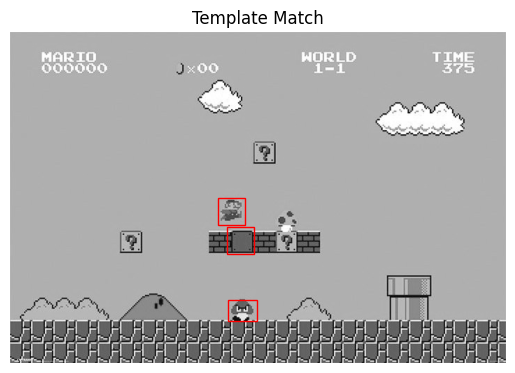

In [15]:
# Empezamos cargando los templates y la imagen principal
image = io.imread('imagenes/notebook_3/super_mario.jpg', as_gray=True)
goomba = io.imread('imagenes/notebook_3/goomba.jpg', as_gray=True) 
brick  = io.imread('imagenes/notebook_3/brick.jpg', as_gray=True)
mario  = io.imread('imagenes/notebook_3/mario.jpg', as_gray=True)

# Construimos el plot de la imagen base, añadimos los plt.Rectangle's correspondientes a los matches y dibujamos todo
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

add_match_rectangle(ax, image, goomba)
add_match_rectangle(ax, image, brick)
add_match_rectangle(ax, image, mario)

plt.title("Template Match")
plt.axis('off')
plt.show()